<a href="https://colab.research.google.com/github/ppunkz/Portfolio/blob/master/Covariate%20shift%20testing%20on%20avocado%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics


In [ ]:
df = pd.read_csv('avocado.csv')

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [ ]:
df.nunique()

Unnamed: 0         53
Date              169
AveragePrice      259
Total Volume    18237
4046            17702
4225            18103
4770            12071
Total Bags      18097
Small Bags      17321
Large Bags      15082
XLarge Bags      5588
type                2
year                4
region             54
dtype: int64

In [ ]:
df = df.drop('Unnamed: 0', axis =1)
df = df.drop('Date', axis =1)

In [ ]:
msk = np.random.rand(len(df_dummy)) < 0.7
train = df[msk]
test = df[~msk]

In [ ]:
#adding a column to identify whether a row comes from train or not
test['is_train'] = 0
train['is_train'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_combine = pd.concat([train, test], axis=0, ignore_index=True, sort=True)
df_dummy = pd.get_dummies(df_combine)
df_dummy

,4046,4225,4770,AveragePrice,Large Bags,Small Bags,Total Bags,Total Volume,XLarge Bags,is_train,year,region_Albany,region_Atlanta,region_BaltimoreWashington,region_Boise,region_Boston,region_BuffaloRochester,region_California,region_Charlotte,region_Chicago,region_CincinnatiDayton,region_Columbus,region_DallasFtWorth,region_Denver,region_Detroit,region_GrandRapids,region_GreatLakes,region_HarrisburgScranton,region_HartfordSpringfield,region_Houston,region_Indianapolis,region_Jacksonville,region_LasVegas,region_LosAngeles,region_Louisville,region_MiamiFtLauderdale,region_Midsouth,region_Nashville,region_NewOrleansMobile,region_NewYork,region_Northeast,region_NorthernNewEngland,region_Orlando,region_Philadelphia,region_PhoenixTucson,region_Pittsburgh,region_Plains,region_Portland,region_RaleighGreensboro,region_RichmondNorfolk,region_Roanoke,region_Sacramento,region_SanDiego,region_SanFrancisco,region_Seattle,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,type_conventional,type_organic
0,1036.74,54454.85,48.16,1.33,93.25,8603.62,8696.87,64236.62,0.00,1,2015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,794.70,109149.67,130.50,0.93,103.14,8042.21,8145.35,118220.22,0.00,1,2015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1132.00,71976.41,72.58,1.08,133.76,5677.40,5811.16,78992.15,0.00,1,2015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,941.48,43838.39,75.78,1.28,197.69,5986.26,6183.95,51039.60,0.00,1,2015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1184.27,48067.99,43.61,1.26,127.44,6556.47,6683.91,55979.78,0.00,1,2015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,24732.55,61713.53,243.00,1.47,99810.80,88497.05,188559.45,275248.53,251.60,0,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
18245,34734.97,62967.74,157.77,1.48,95544.39,103761.55,199330.12,297190.60,24.18,0,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
18246,2046.96,1529.20,0.00,1.63,431.85,13066.82,13498.67,17074.83,0.00,0,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
18247,1191.70,3431.50,0.00,1.71,324.80,8940.04,9264.84,13888.04,0.00,0,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
y = df_dummy['is_train'].values #labels
x = df_dummy.drop('is_train', axis=1).values #covariates or our independent variables

tst, trn = test.values, train.values

In [ ]:
m = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
predictions = np.zeros(y.shape) #creating an empty prediction array

In [ ]:
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=100)
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
 X_train, X_test = x[train_idx], x[test_idx]
 y_train, y_test = y[train_idx], y[test_idx]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)
print('train2 shape:', X_train.shape, 'test2 shape:', X_test.shape)

train2 shape: (12774, 66) test2 shape: (5475, 66)


In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_test_score = rfc.predict_proba(X_test)  

In [ ]:
print('AUC score: ', round(roc_auc_score(y_test, y_test_score[:,1]), 4))


AUC score:  0.4958


In [ ]:
 m.fit(X_train, y_train)
 probs = m.predict_proba(X_test)[:, 1] #calculating the probability
 predictions[test_idx] = probs

In [ ]:
print('ROC-AUC for train and test distributions:', round(roc_auc_score(y, predictions), 5))

ROC-AUC for train and test distributions: 0.50004


(array([269.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 643.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

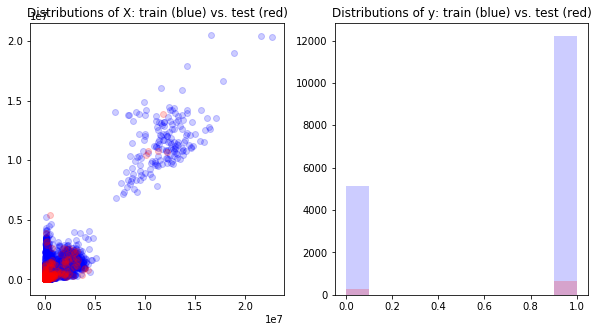

In [ ]:
f,axs=plt.subplots(1,2, figsize=(10,5))
axs[0].scatter(X_train[:,0],X_train[:,1], color='b', alpha=.2)
axs[0].scatter(X_test[:,0],X_test[:,1], color='r', alpha=.2)
axs[0].set_title('Distributions of X: train (blue) vs. test (red)')

axs[1].set_title('Distributions of y: train (blue) vs. test (red)')
axs[1].hist(y_train, color='b', alpha=.2)
axs[1].hist(y_test, color='r', alpha=.2)